In [1]:
#COMP 478/6771 - Image Processing --- Winter 2022
#Jupyter Notebook of final project
#Project title: Multi-class surface defect classification on 3D concrete printing structures using deep learning
#Students: Vasileios Sergis (ID: 40239274) Hua Wang (ID: )
import torch
import torch.nn as nn  
import torch.optim as optim 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
import torchvision
import os
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler as WRS
import numpy as np
from torch.optim import Adam

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
    
        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda


In [4]:
# Hyperparameters
in_channel = 3
num_classes = 4
batch_size = 32

my_transforms= transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((224, 224)),  
    transforms.RandomRotation(degrees=45),  # Perhaps a random rotation from -45 to 45 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flips the image horizontally with probability 0.5
    transforms.RandomVerticalFlip(p=0.05),  # Flips image vertically with probability 0.05
    transforms.RandomGrayscale(p=0.2),  # Converts to grayscale with probability 0.2
    transforms.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch
])

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/My Drive/Colab Notebooks/comp6771/dataset/'  # Google drive
dataset = ImageFolder(path, transform=my_transforms)
print(f'number of images: {len(dataset)}')
print(f'number of classes: {len(dataset.classes)}')

number of images: 2293
number of classes: 4


In [8]:
339+1196+700+49 ##total number of images

class_weights=[]

In [9]:
#Since we have imblanced dataset, in this section, we are resampling the data images for classes with sample weight to avoid the bias
total=len(dataset) #339+1196+700+49+10
tr=int(np.floor(total*0.7))
te=int(total-tr)
train_set, test_set = torch.utils.data.random_split(dataset, [tr, te])

class_weights=[]
for root, subdir, files in sorted(os.walk(path)):
  if len(files)>0:
    print(len(files))
    class_weights.append(1/len(files))

sample_weights = [0]*len(train_set)

for idx, (data,label) in enumerate(train_set):
    class_weight=class_weights[label]
    sample_weights[idx]=class_weight
sampler=WRS(sample_weights, num_samples=len(sample_weights), replacement=True)

#load the data with reblanced samples
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


347
49
1196
701


In [10]:
print(class_weights)

[0.002881844380403458, 0.02040816326530612, 0.0008361204013377926, 0.0014265335235378032]


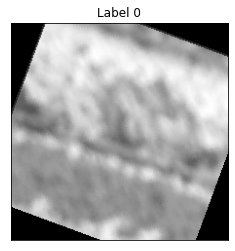

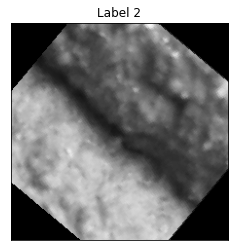

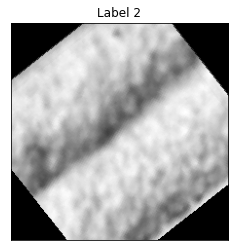

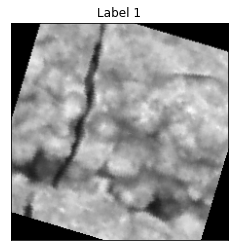

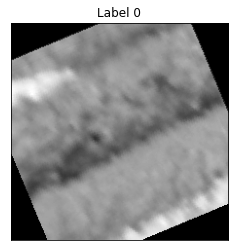

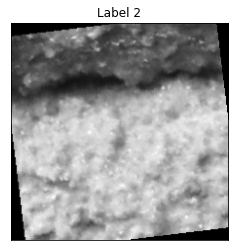

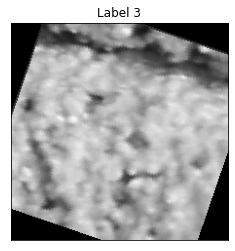

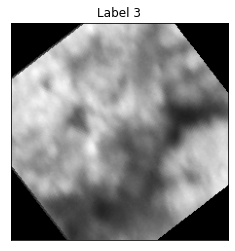

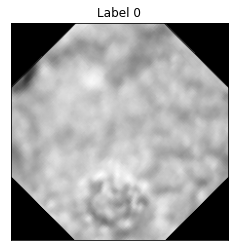

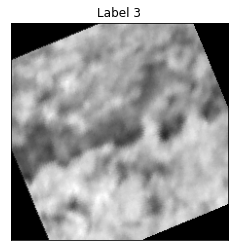

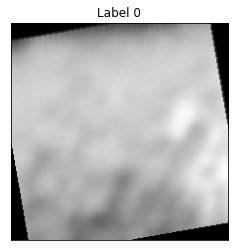

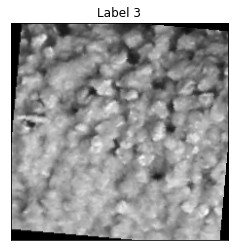

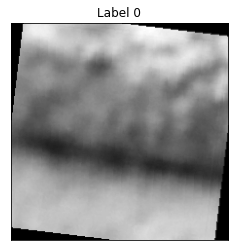

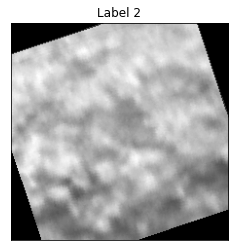

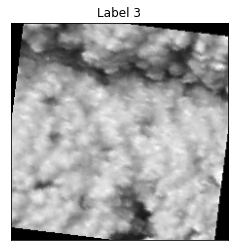

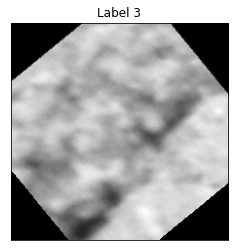

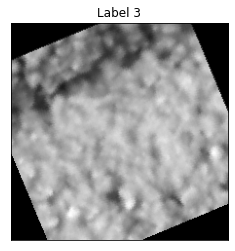

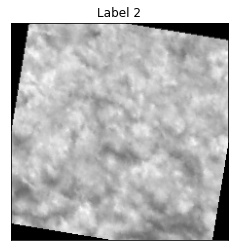

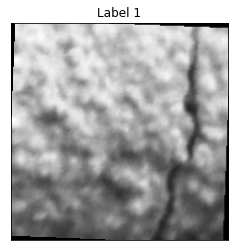

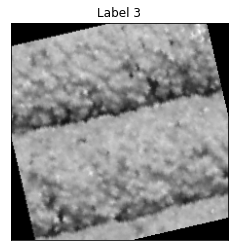

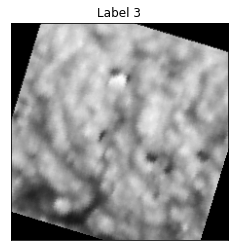

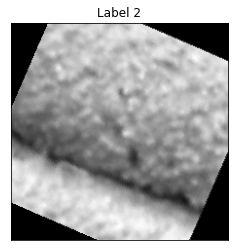

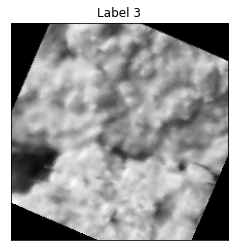

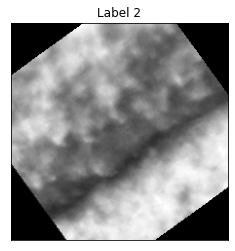

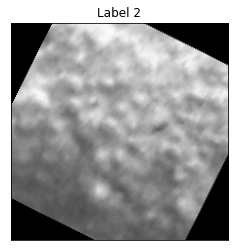

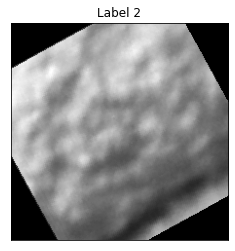

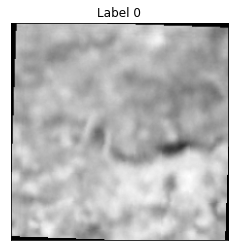

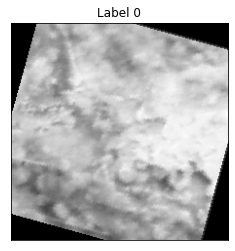

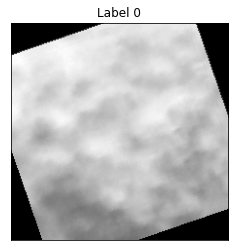

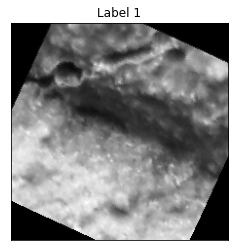

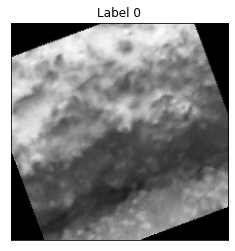

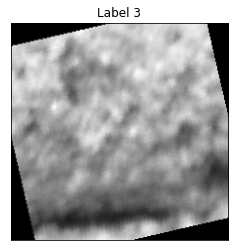

torch.Size([224, 224])


In [11]:
example=iter(train_loader)
sample, label = example.next()
for i in range(len(sample)):
    plt.title('Label ' + str(label[i].item()))
    plt.imshow(sample[i][0], cmap='gray')
    plt.xticks([]),plt.yticks([])
    plt.show()
print(sample[1][0].shape)

In [12]:
from tqdm import tqdm
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train_model(model,train_loader,criterion,optimizer,learning_rate,num_epochs):

    # Train Network
    model.train()
    for epoch in tqdm(range(num_epochs)):
        losses = []

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        print(f" Cost at epoch {epoch} is {sum(losses)/len(losses)}")

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model, mode="Train"):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        pred_labels = []
        real_labels = []
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            real_labels += y.cpu()

            scores = model(x)
            _, predictions = scores.max(1)

            pred_labels += predictions.cpu()
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        cm = confusion_matrix(real_labels, pred_labels)
        class_names = [0,1,2,3]

        # Plot confusion matrix in a beautiful manner
        fig = plt.figure(figsize=(8, 7),dpi=80)
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
        # labels, title and ticks
        ax.set_xlabel('Predicted', fontsize=20)
        ax.xaxis.set_label_position('bottom')
        plt.xticks(rotation=90)
        ax.xaxis.set_ticklabels(class_names, fontsize = 10)
        ax.xaxis.tick_bottom()

        ax.set_ylabel('True', fontsize=20)
        ax.yaxis.set_ticklabels(class_names, fontsize = 10)
        plt.yticks(rotation=0)

        plt.title(mode+' Confusion Matrix', fontsize=20)

        plt.savefig(model.__class__.__name__+'_'+mode+'.png')
        plt.show()                  

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )
    model.train()

In [13]:
learning_rate = 1e-4
num_epochs = 15

# Model
googlenet = torchvision.models.googlenet(pretrained=True)

#change fc layer output dimension 
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, num_classes)

googlenet.to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.fc.parameters(), lr=learning_rate)

# Experiment with pretained GoogleNet, in this case we froze the googlenet only trained custom classifier layer
# Train Network
train_model(googlenet, train_loader, criterion, optimizer, learning_rate, num_epochs)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

  7%|▋         | 1/15 [00:12<02:49, 12.09s/it]

 Cost at epoch 0 is 1.3680164393256693


 13%|█▎        | 2/15 [00:22<02:24, 11.14s/it]

 Cost at epoch 1 is 1.3272930921292772


 20%|██        | 3/15 [00:32<02:06, 10.56s/it]

 Cost at epoch 2 is 1.292055789162131


 27%|██▋       | 4/15 [00:41<01:48,  9.89s/it]

 Cost at epoch 3 is 1.2624229145985024


 33%|███▎      | 5/15 [00:51<01:39,  9.99s/it]

 Cost at epoch 4 is 1.225175004379422


 40%|████      | 6/15 [01:02<01:31, 10.21s/it]

 Cost at epoch 5 is 1.2071673051983702


 47%|████▋     | 7/15 [01:12<01:22, 10.30s/it]

 Cost at epoch 6 is 1.1889038646922392


 53%|█████▎    | 8/15 [01:22<01:12, 10.33s/it]

 Cost at epoch 7 is 1.152196302133448


 60%|██████    | 9/15 [01:32<01:00, 10.09s/it]

 Cost at epoch 8 is 1.142076158056072


 67%|██████▋   | 10/15 [01:41<00:49,  9.89s/it]

 Cost at epoch 9 is 1.118923793820774


 73%|███████▎  | 11/15 [01:52<00:39,  9.95s/it]

 Cost at epoch 10 is 1.0950808174469893


 80%|████████  | 12/15 [02:04<00:31, 10.66s/it]

 Cost at epoch 11 is 1.070445241881352


 87%|████████▋ | 13/15 [02:13<00:20, 10.35s/it]

 Cost at epoch 12 is 1.0955863957311593


 93%|█████████▎| 14/15 [02:22<00:09,  9.86s/it]

 Cost at epoch 13 is 1.061644922284519


100%|██████████| 15/15 [02:31<00:00, 10.09s/it]

 Cost at epoch 14 is 1.0417696471307791


Checking accuracy on Training Set


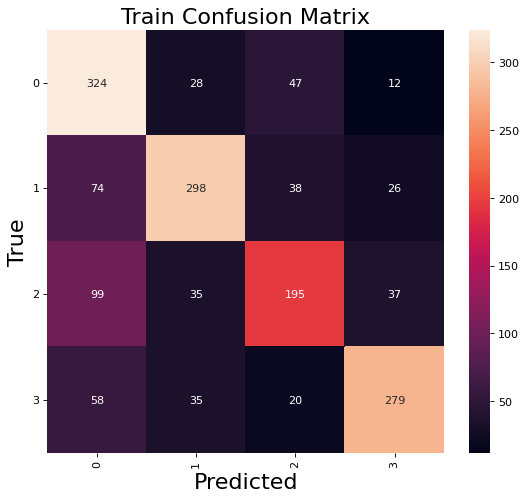

Got 1096 / 1605 with accuracy 68.29
Checking accuracy on Test Set


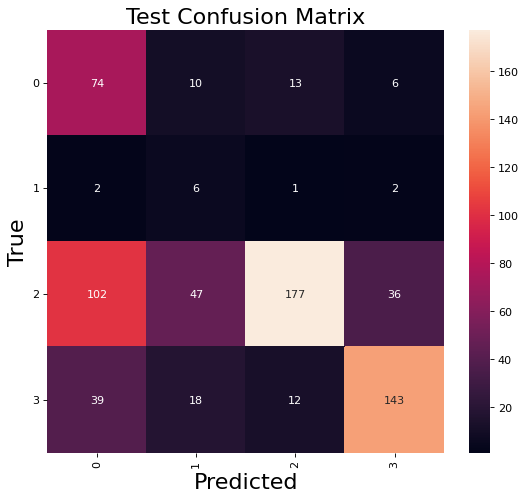

Got 400 / 688 with accuracy 58.14


In [14]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, googlenet)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, googlenet,'Test')

In [15]:
learning_rate = 1e-4
num_epochs = 15

# Model
googlenet = torchvision.models.googlenet(pretrained=True)

#change fc layer output dimension 
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, num_classes)

googlenet.to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=learning_rate)

# Experiment with pretained GoogleNet again,
# this time we fine-turned the whole network with our custom classifier layer
# Train Network
train_model(googlenet, train_loader, criterion, optimizer, learning_rate, num_epochs)

  7%|▋         | 1/15 [00:11<02:35, 11.09s/it]

 Cost at epoch 0 is 1.0137297347480176


 13%|█▎        | 2/15 [00:22<02:24, 11.13s/it]

 Cost at epoch 1 is 0.4838779708918403


 20%|██        | 3/15 [00:33<02:12, 11.07s/it]

 Cost at epoch 2 is 0.32736275944055293


 27%|██▋       | 4/15 [00:44<02:01, 11.02s/it]

 Cost at epoch 3 is 0.24826154594912248


 33%|███▎      | 5/15 [00:55<01:49, 11.00s/it]

 Cost at epoch 4 is 0.22372867459175633


 40%|████      | 6/15 [01:06<01:38, 10.98s/it]

 Cost at epoch 5 is 0.20533697292500852


 47%|████▋     | 7/15 [01:17<01:27, 10.98s/it]

 Cost at epoch 6 is 0.23518350859190904


 53%|█████▎    | 8/15 [01:28<01:16, 10.97s/it]

 Cost at epoch 7 is 0.1856747072409181


 60%|██████    | 9/15 [01:38<01:05, 10.96s/it]

 Cost at epoch 8 is 0.18297439528738751


 67%|██████▋   | 10/15 [01:49<00:54, 10.97s/it]

 Cost at epoch 9 is 0.15485896772759802


 73%|███████▎  | 11/15 [02:04<00:47, 12.00s/it]

 Cost at epoch 10 is 0.12248125422161583


 80%|████████  | 12/15 [02:15<00:35, 11.68s/it]

 Cost at epoch 11 is 0.11618638968131706


 87%|████████▋ | 13/15 [02:26<00:22, 11.46s/it]

 Cost at epoch 12 is 0.13106910245237396


 93%|█████████▎| 14/15 [02:37<00:11, 11.31s/it]

 Cost at epoch 13 is 0.10907865322980226


100%|██████████| 15/15 [02:48<00:00, 11.21s/it]

 Cost at epoch 14 is 0.08500048220522848


Checking accuracy on Training Set


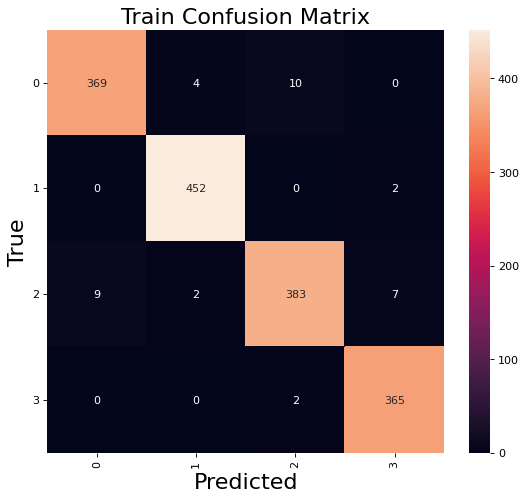

Got 1569 / 1605 with accuracy 97.76
Checking accuracy on Test Set


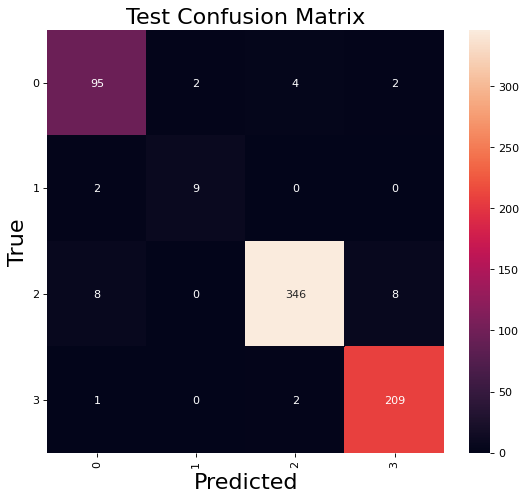

Got 659 / 688 with accuracy 95.78


In [16]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, googlenet)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, googlenet,'Test')

In [17]:
learning_rate = 1e-4
num_epochs = 15

# Model
resnet18 = torchvision.models.resnet18(pretrained=True)


#change fc layer output dimension 
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)

resnet18.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=learning_rate)

# Experiment with pretained Resnet18, fine-turning the whole network with our custom classifier layer
# Train Network
train_model(resnet18,train_loader,criterion,optimizer,learning_rate,num_epochs)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  7%|▋         | 1/15 [00:08<01:55,  8.27s/it]

 Cost at epoch 0 is 0.716878066095067


 13%|█▎        | 2/15 [00:16<01:46,  8.22s/it]

 Cost at epoch 1 is 0.3328998454061209


 20%|██        | 3/15 [00:27<01:51,  9.31s/it]

 Cost at epoch 2 is 0.2872871029026368


 27%|██▋       | 4/15 [00:37<01:46,  9.70s/it]

 Cost at epoch 3 is 0.22134861896070196


 33%|███▎      | 5/15 [00:48<01:40, 10.07s/it]

 Cost at epoch 4 is 0.21026657404852847


 40%|████      | 6/15 [00:59<01:33, 10.42s/it]

 Cost at epoch 5 is 0.19615175125791745


 47%|████▋     | 7/15 [01:08<01:20, 10.04s/it]

 Cost at epoch 6 is 0.15775851481685452


 53%|█████▎    | 8/15 [01:18<01:09,  9.91s/it]

 Cost at epoch 7 is 0.16969983140919723


 60%|██████    | 9/15 [01:27<00:59,  9.90s/it]

 Cost at epoch 8 is 0.1527861369883313


 67%|██████▋   | 10/15 [01:38<00:49,  9.99s/it]

 Cost at epoch 9 is 0.15578138777146153


 73%|███████▎  | 11/15 [01:47<00:38,  9.73s/it]

 Cost at epoch 10 is 0.13863426819443703


 80%|████████  | 12/15 [01:57<00:29,  9.86s/it]

 Cost at epoch 11 is 0.13166182349417724


 87%|████████▋ | 13/15 [02:06<00:19,  9.60s/it]

 Cost at epoch 12 is 0.1419551020086396


 93%|█████████▎| 14/15 [02:14<00:09,  9.18s/it]

 Cost at epoch 13 is 0.1314488576871215


100%|██████████| 15/15 [02:24<00:00,  9.60s/it]

 Cost at epoch 14 is 0.11912247454564945


Checking accuracy on Training Set


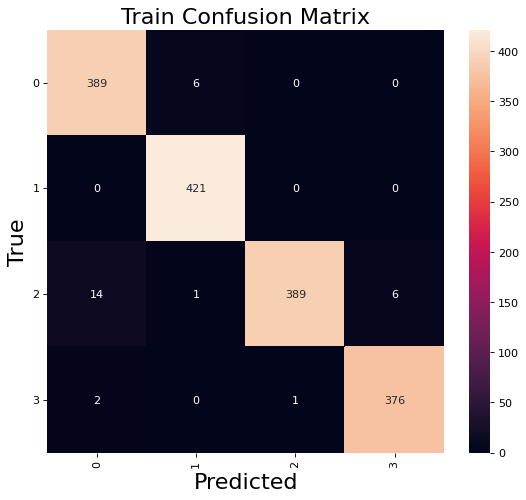

Got 1575 / 1605 with accuracy 98.13
Checking accuracy on Test Set


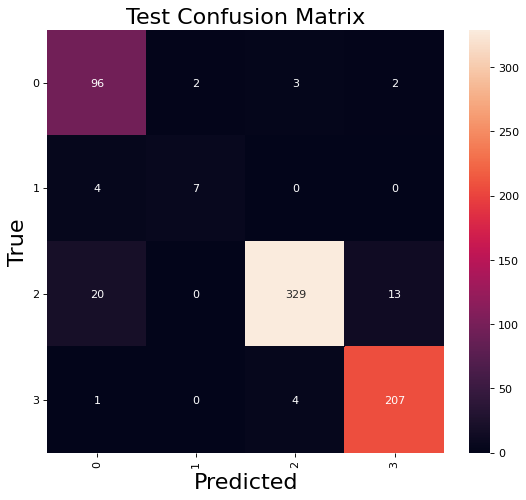

Got 639 / 688 with accuracy 92.88


In [18]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, resnet18)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, resnet18,'Test')

In [19]:
learning_rate = 1e-4
num_epochs = 15

# Model
alexnet = torchvision.models.alexnet(pretrained=True)

#change fc layer output dimension 
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, num_classes)

alexnet.to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=learning_rate)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [20]:
# Experiment with pretained AlexNet, fine-turning the whole network with our custom classifier layer
# Train Network
train_model(alexnet,train_loader,criterion,optimizer,learning_rate,num_epochs)

  7%|▋         | 1/15 [00:08<02:02,  8.76s/it]

 Cost at epoch 0 is 1.189396203732958


 13%|█▎        | 2/15 [00:17<01:54,  8.80s/it]

 Cost at epoch 1 is 0.7970051929062488


 20%|██        | 3/15 [00:24<01:37,  8.14s/it]

 Cost at epoch 2 is 0.6007597294508242


 27%|██▋       | 4/15 [00:32<01:26,  7.84s/it]

 Cost at epoch 3 is 0.442217841269631


 33%|███▎      | 5/15 [00:39<01:16,  7.67s/it]

 Cost at epoch 4 is 0.4269098217288653


 40%|████      | 6/15 [00:46<01:07,  7.54s/it]

 Cost at epoch 5 is 0.3369033742769092


 47%|████▋     | 7/15 [00:55<01:03,  7.89s/it]

 Cost at epoch 6 is 0.37071044757670046


 53%|█████▎    | 8/15 [01:04<00:56,  8.14s/it]

 Cost at epoch 7 is 0.27158354456518213


 60%|██████    | 9/15 [01:13<00:51,  8.57s/it]

 Cost at epoch 8 is 0.28332508808257534


 67%|██████▋   | 10/15 [01:21<00:40,  8.19s/it]

 Cost at epoch 9 is 0.2283894177161011


 73%|███████▎  | 11/15 [01:29<00:32,  8.20s/it]

 Cost at epoch 10 is 0.2882566884452221


 80%|████████  | 12/15 [01:39<00:26,  8.81s/it]

 Cost at epoch 11 is 0.24643288070664687


 87%|████████▋ | 13/15 [01:46<00:16,  8.38s/it]

 Cost at epoch 12 is 0.22223997726013847


 93%|█████████▎| 14/15 [01:54<00:08,  8.06s/it]

 Cost at epoch 13 is 0.19769273961291595


100%|██████████| 15/15 [02:01<00:00,  8.11s/it]

 Cost at epoch 14 is 0.2060473136165563


Checking accuracy on Training Set by using Alexnet


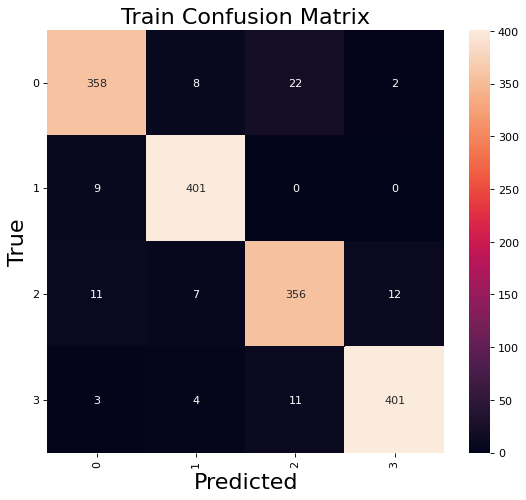

Got 1516 / 1605 with accuracy 94.45
Checking accuracy on Test Set by using Alexnet


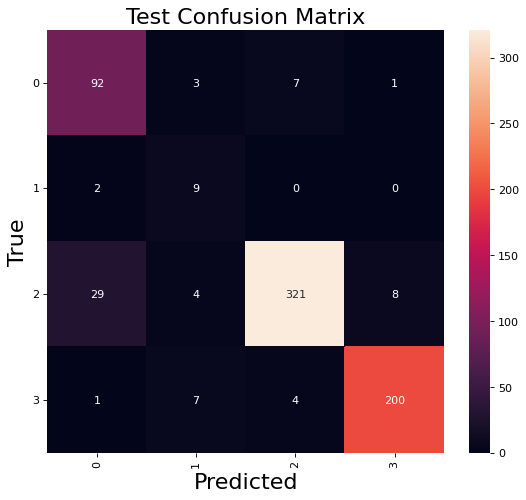

Got 622 / 688 with accuracy 90.41


In [21]:
print("Checking accuracy on Training Set by using Alexnet")
check_accuracy(train_loader, alexnet)

print("Checking accuracy on Test Set by using Alexnet")
check_accuracy(test_loader, alexnet,'Test')

In [22]:
learning_rate = 1e-4
num_epochs = 15

# Model
vgg16 = torchvision.models.vgg16(pretrained=True)

#change fc layer output dimension 
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=learning_rate)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [23]:
# Experiment with pretained Vgg16, only fine-turning custom classifier layer without update the pretrained weights
# Train Network
train_model(vgg16,train_loader,criterion,optimizer,learning_rate,num_epochs)

  7%|▋         | 1/15 [00:13<03:11, 13.68s/it]

 Cost at epoch 0 is 1.3628414635564767


 13%|█▎        | 2/15 [00:25<02:44, 12.66s/it]

 Cost at epoch 1 is 1.340782123453477


 20%|██        | 3/15 [00:37<02:28, 12.34s/it]

 Cost at epoch 2 is 1.293306244354622


 27%|██▋       | 4/15 [00:50<02:16, 12.39s/it]

 Cost at epoch 3 is 1.2788534351423675


 33%|███▎      | 5/15 [01:02<02:02, 12.24s/it]

 Cost at epoch 4 is 1.2428715229034424


 40%|████      | 6/15 [01:13<01:49, 12.14s/it]

 Cost at epoch 5 is 1.2693784610897887


 47%|████▋     | 7/15 [01:25<01:36, 12.08s/it]

 Cost at epoch 6 is 1.2388012081969018


 53%|█████▎    | 8/15 [01:38<01:25, 12.19s/it]

 Cost at epoch 7 is 1.2333224100225113


 60%|██████    | 9/15 [01:50<01:12, 12.12s/it]

 Cost at epoch 8 is 1.2038859502941954


 67%|██████▋   | 10/15 [02:02<01:00, 12.07s/it]

 Cost at epoch 9 is 1.210419778730355


 73%|███████▎  | 11/15 [02:14<00:48, 12.15s/it]

 Cost at epoch 10 is 1.1950307056015612


 80%|████████  | 12/15 [02:26<00:36, 12.09s/it]

 Cost at epoch 11 is 1.1725376552226496


 87%|████████▋ | 13/15 [02:38<00:24, 12.05s/it]

 Cost at epoch 12 is 1.1703875625834745


 93%|█████████▎| 14/15 [02:50<00:12, 12.02s/it]

 Cost at epoch 13 is 1.1631214022636414


100%|██████████| 15/15 [03:02<00:00, 12.16s/it]

 Cost at epoch 14 is 1.1557281882155175


Checking accuracy on Training Set


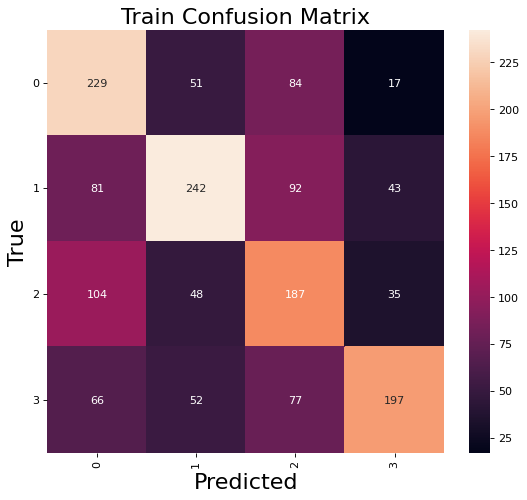

Got 855 / 1605 with accuracy 53.27
Checking accuracy on Test Set


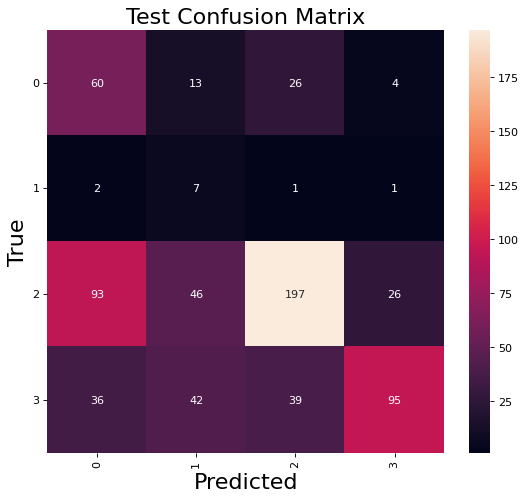

Got 359 / 688 with accuracy 52.18


In [24]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, vgg16)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, vgg16,'Test')

In [25]:
learning_rate = 1e-4
num_epochs = 42

# Model
vgg16 = torchvision.models.vgg16(pretrained=False)

#change fc layer output dimension 
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate)


In [26]:
# Experiment with pretained Vgg16 without pretrained weights
# Train Network
train_model(vgg16,train_loader,criterion,optimizer,learning_rate,num_epochs)

  2%|▏         | 1/42 [00:13<08:53, 13.00s/it]

 Cost at epoch 0 is 1.3879650457232606


  5%|▍         | 2/42 [00:25<08:39, 12.99s/it]

 Cost at epoch 1 is 1.3856096361197678


  7%|▋         | 3/42 [00:38<08:26, 12.99s/it]

 Cost at epoch 2 is 1.3878810429105572


 10%|▉         | 4/42 [00:51<08:13, 12.99s/it]

 Cost at epoch 3 is 1.3871434599745507


 12%|█▏        | 5/42 [01:04<08:00, 12.99s/it]

 Cost at epoch 4 is 1.3818793390311448


 14%|█▍        | 6/42 [01:17<07:47, 12.99s/it]

 Cost at epoch 5 is 1.3850976649452658


 17%|█▋        | 7/42 [01:30<07:34, 12.99s/it]

 Cost at epoch 6 is 1.3864465274062812


 19%|█▉        | 8/42 [01:46<07:51, 13.86s/it]

 Cost at epoch 7 is 1.3872670800078148


 21%|██▏       | 9/42 [02:01<07:42, 14.03s/it]

 Cost at epoch 8 is 1.3948895300135893


 24%|██▍       | 10/42 [02:15<07:28, 14.01s/it]

 Cost at epoch 9 is 1.3856421405193853


 26%|██▌       | 11/42 [02:28<07:13, 13.97s/it]

 Cost at epoch 10 is 1.3864122746037502


 29%|██▊       | 12/42 [02:42<06:59, 13.98s/it]

 Cost at epoch 11 is 1.3862496427461213


 31%|███       | 13/42 [02:57<06:48, 14.08s/it]

 Cost at epoch 12 is 1.3852127556707345


 33%|███▎      | 14/42 [03:10<06:25, 13.75s/it]

 Cost at epoch 13 is 1.3874262664832322


 36%|███▌      | 15/42 [03:23<06:05, 13.52s/it]

 Cost at epoch 14 is 1.3853530603296615


 38%|███▊      | 16/42 [03:36<05:47, 13.36s/it]

 Cost at epoch 15 is 1.387118937922459


 40%|████      | 17/42 [03:49<05:31, 13.25s/it]

 Cost at epoch 16 is 1.3855166645611035


 43%|████▎     | 18/42 [04:02<05:16, 13.17s/it]

 Cost at epoch 17 is 1.385524777805104


 45%|████▌     | 19/42 [04:15<05:04, 13.24s/it]

 Cost at epoch 18 is 1.384898017434513


 48%|████▊     | 20/42 [04:29<04:55, 13.41s/it]

 Cost at epoch 19 is 1.3864885404998182


 50%|█████     | 21/42 [04:42<04:39, 13.29s/it]

 Cost at epoch 20 is 1.3863643314324172


 52%|█████▏    | 22/42 [04:55<04:23, 13.20s/it]

 Cost at epoch 21 is 1.3876254254696416


 55%|█████▍    | 23/42 [05:08<04:09, 13.14s/it]

 Cost at epoch 22 is 1.3859978470147825


 57%|█████▋    | 24/42 [05:23<04:06, 13.70s/it]

 Cost at epoch 23 is 1.3830993432624668


 60%|█████▉    | 25/42 [05:36<03:52, 13.66s/it]

 Cost at epoch 24 is 1.386110686788372


 62%|██████▏   | 26/42 [05:50<03:35, 13.49s/it]

 Cost at epoch 25 is 1.3841394092522414


 64%|██████▍   | 27/42 [06:03<03:20, 13.34s/it]

 Cost at epoch 26 is 1.3874368644228168


 67%|██████▋   | 28/42 [06:16<03:05, 13.24s/it]

 Cost at epoch 27 is 1.3858713238847022


 69%|██████▉   | 29/42 [06:29<02:51, 13.17s/it]

 Cost at epoch 28 is 1.3857363392325008


 71%|███████▏  | 30/42 [06:42<02:37, 13.13s/it]

 Cost at epoch 29 is 1.3859006096335018


 74%|███████▍  | 31/42 [06:55<02:23, 13.09s/it]

 Cost at epoch 30 is 1.3865504521949619


 76%|███████▌  | 32/42 [07:08<02:11, 13.18s/it]

 Cost at epoch 31 is 1.3854784334407133


 79%|███████▊  | 33/42 [07:21<01:59, 13.25s/it]

 Cost at epoch 32 is 1.3879255617366117


 81%|████████  | 34/42 [07:34<01:45, 13.17s/it]

 Cost at epoch 33 is 1.386964804985944


 83%|████████▎ | 35/42 [07:47<01:31, 13.12s/it]

 Cost at epoch 34 is 1.3831927542592966


 86%|████████▌ | 36/42 [08:00<01:18, 13.08s/it]

 Cost at epoch 35 is 1.383952914499769


 88%|████████▊ | 37/42 [08:13<01:05, 13.06s/it]

 Cost at epoch 36 is 1.384942473149767


 90%|█████████ | 38/42 [08:26<00:52, 13.04s/it]

 Cost at epoch 37 is 1.383330642008314


 93%|█████████▎| 39/42 [08:39<00:39, 13.03s/it]

 Cost at epoch 38 is 1.3830880651287003


 95%|█████████▌| 40/42 [08:54<00:26, 13.47s/it]

 Cost at epoch 39 is 1.384106016626545


 98%|█████████▊| 41/42 [09:07<00:13, 13.51s/it]

 Cost at epoch 40 is 1.3853589039222867


100%|██████████| 42/42 [09:21<00:00, 13.37s/it]

 Cost at epoch 41 is 1.387033883263083


Checking accuracy on Training Set


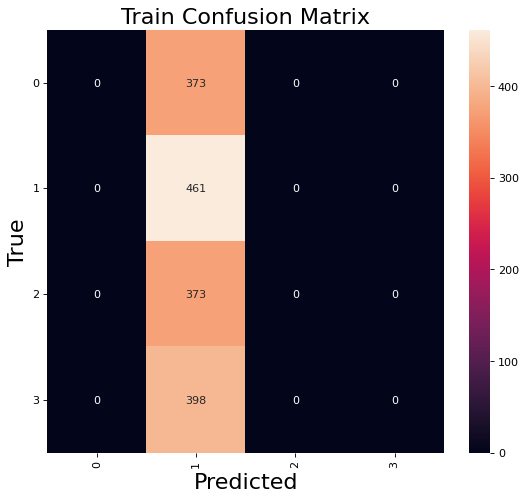

Got 461 / 1605 with accuracy 28.72
Checking accuracy on Test Set


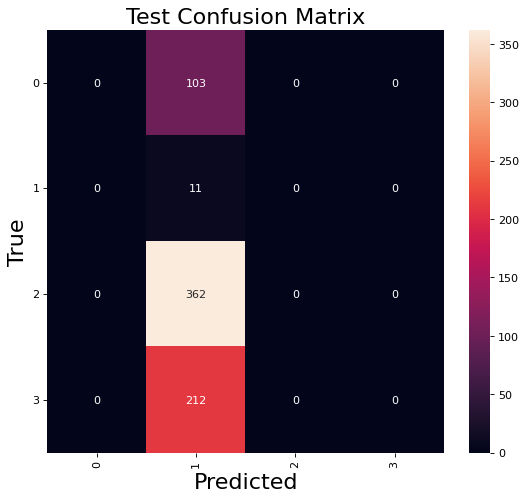

Got 11 / 688 with accuracy 1.60


In [27]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, vgg16)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, vgg16,'Test')

In [28]:
learning_rate = 1e-4
num_epochs = 15

# Model
vgg16 = torchvision.models.vgg16(pretrained=True)

#change fc layer output dimension 
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate)


In [29]:
# Experiment with pretained Vgg16, fine-turning the whole network with our custom classifier layer
# Train Network
train_model(vgg16,train_loader,criterion,optimizer,learning_rate,num_epochs)

  7%|▋         | 1/15 [00:12<03:01, 12.98s/it]

 Cost at epoch 0 is 1.2207060760142756


 13%|█▎        | 2/15 [00:25<02:48, 12.99s/it]

 Cost at epoch 1 is 0.8198484375196344


 20%|██        | 3/15 [00:38<02:35, 12.99s/it]

 Cost at epoch 2 is 0.6600602000367408


 27%|██▋       | 4/15 [00:51<02:22, 12.99s/it]

 Cost at epoch 3 is 0.514935679879843


 33%|███▎      | 5/15 [01:04<02:09, 12.99s/it]

 Cost at epoch 4 is 0.42207736565786247


 40%|████      | 6/15 [01:17<01:56, 12.99s/it]

 Cost at epoch 5 is 0.456455299375104


 47%|████▋     | 7/15 [01:30<01:43, 12.99s/it]

 Cost at epoch 6 is 0.34702694167693454


 53%|█████▎    | 8/15 [01:43<01:30, 12.99s/it]

 Cost at epoch 7 is 0.29780595851879493


 60%|██████    | 9/15 [01:56<01:17, 12.99s/it]

 Cost at epoch 8 is 0.38436975315505384


 67%|██████▋   | 10/15 [02:09<01:04, 12.99s/it]

 Cost at epoch 9 is 0.29508348642026677


 73%|███████▎  | 11/15 [02:22<00:51, 12.99s/it]

 Cost at epoch 10 is 0.2529059116016416


 80%|████████  | 12/15 [02:35<00:38, 12.99s/it]

 Cost at epoch 11 is 0.2220940832413879


 87%|████████▋ | 13/15 [02:48<00:25, 12.99s/it]

 Cost at epoch 12 is 0.1978136989123681


 93%|█████████▎| 14/15 [03:01<00:12, 12.99s/it]

 Cost at epoch 13 is 0.25940447917902004


100%|██████████| 15/15 [03:14<00:00, 12.99s/it]

 Cost at epoch 14 is 0.25291794049097044


Checking accuracy on Training Set


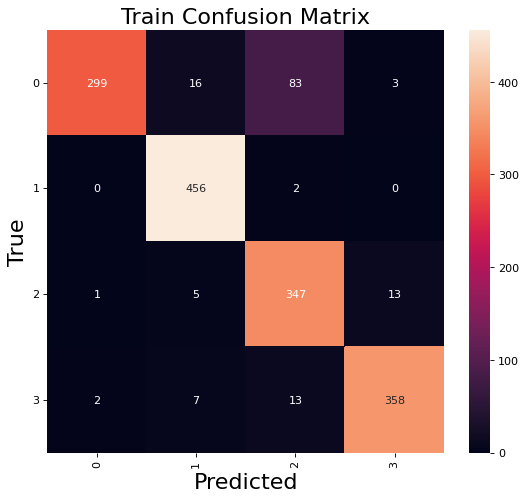

Got 1460 / 1605 with accuracy 90.97
Checking accuracy on Test Set


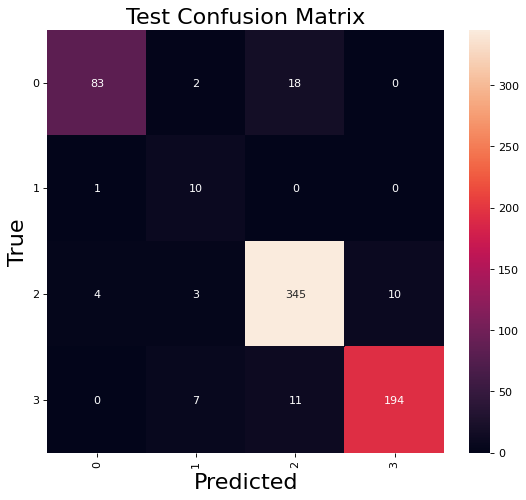

Got 632 / 688 with accuracy 91.86


In [30]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, vgg16)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, vgg16,'Test')

In [39]:
import torch.nn.functional as F

#define the custom convolutional network 
class conv_net(nn.Module):
    def __init__(self, device='cpu'):
        """ Initialize conv_net
        Args:
            None
        Returns:
            None
        """
        super(conv_net,self).__init__()
        # Feautre extraction sequence 
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 100, kernel_size = 11, stride = 3) #[(224+2*0-11)/3 +1] = 72
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2) #[(72+2*0-3)/2 +1]= 36
        self.conv2 = nn.Conv2d(in_channels = 100, out_channels = 512, kernel_size = 3, stride = 1) #[(35+2*0-3)/1 +1]= 33 
        self.conv3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2) #[(33+2*0-3)/2 +1]= 16 
        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2) #[(16+2*0-3)/2 +1]= 7
        self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1) #[(7+2*0-3)/1 +1]= 5
        self.max_pool3 = nn.MaxPool2d(kernel_size = 3, stride = 1) # [(5+2*0-3)/1 +1]= 3 
        
        # Linear classifier 
        self.linear = nn.Linear(in_features = 256*3*3 , out_features = 4)
        self.device = device
        self.params = {}
        self.init_weights()

    def init_weights(self):
        #Initialize all convolutional layers and linear layers weight with xaiver initialization method
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)

        nn.init.xavier_uniform_(self.conv4.weight)
        nn.init.zeros_(self.conv4.bias)
        
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
        
    
    def forward(self,x):
        """ Perform forward pass
        Args:
            x (torch.tensor): tensor of images of shape  (B, C, H, W)
        Returns:
            torch.tensor: tesnor of output of shape (B, N_classes)
        """
        
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv4(x))
        x = self.max_pool3(x)
        x = x.reshape(x.shape[0], -1).to(device)
        x = self.linear(x)
        return x
        
model = conv_net()
print(model)

conv_net(
  (conv1): Conv2d(3, 100, kernel_size=(11, 11), stride=(3, 3))
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=2304, out_features=4, bias=True)
)


In [38]:
def Train(model,optimizer,dataloader,device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        optimizer (torch.optim instance)
        dataloader (torch.utils.data.DataLoader instance): dataloader for train set
        device (str): computation device ['cpu','cuda',...]
    Returns:
        list of floats: mini_batch loss sampled every 20 steps for visualization purposes
        list of floats: mini_batch accuracy sampled every 20 steps for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    loss_fn = nn.CrossEntropyLoss()
    for i,(data,label) in enumerate(dataloader):
        #Put data and label on target device
        data=data.to(device)
        label=label.to(device)

        #gradients to zero
        optimizer.zero_grad()
        #Pass data to the model
        scores = model(data) 
        
        loss = loss_fn(scores, label).to(device) # Calculate cross entropy loss
        loss.backward()
        optimizer.step() #Update the weights and biases

        if i % 20 == 0:
          with torch.no_grad():
              loss_tracker.append(loss.item())
              _, predicted = torch.max(scores.data, 1)

              num_correct = (predicted == label).sum().item()
              #print(num_correct)
              num_samples = label.size(0)
              accuracy = num_correct/num_samples*100
              accuracy_tracker.append(accuracy)
          
    return loss_tracker, accuracy_tracker

def Test(model,dataloader,device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        dataloader (torch.utils.data.DataLoader instance)
        device (str): computation device ['cpu','cuda',...]
    Returns:
        floats: test set loss for visualization purposes
        floats: test set accuracy for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    loss_fn = nn.CrossEntropyLoss()
    for i,(data,label) in enumerate(dataloader):
        data=data.to(device=device)
        label=label.to(device=device)
        
        with torch.no_grad():
            #Feedforward NN
            scores = model(data) #CNN

            loss = loss_fn(scores, label).to(device) # Calculate cross entropy loss
            _, predicted = torch.max(scores.data, 1)

            num_correct = (predicted == label).sum().item()
            #print(num_correct)
            num_samples = label.size(0)
            accuracy = num_correct/num_samples*100
        loss_tracker.append(loss.item())
        accuracy_tracker.append(accuracy)
        
    return sum(loss_tracker)/len(loss_tracker), sum(accuracy_tracker)/len(accuracy_tracker)
             

In [ ]:
# Setting hyper parameters
epochs = 50
learning_rate = 0.0001

# et target device for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
print(f'device: {device}')


# Initialize conv_net then Put model parameters on target device
model = conv_net().to(device)


# Initialize Adam optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

train_loss_tracker = []
train_accuracy_tracker = []

test_loss_tracker = []
test_accuracy_tracker = []

for epoch in range(epochs):
    train_loss,train_accuracy = Train(model,optimizer,train_loader,device)
    test_loss , test_accuracy = Test(model,test_loader,device)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print(f'epoch: {epoch}')
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

device: cuda
epoch: 0
	 training loss/accuracy: 1.37/29.17
	 testing loss/accuracy: 1.40/3.98
epoch: 1
	 training loss/accuracy: 1.25/38.54
	 testing loss/accuracy: 1.25/32.67
epoch: 2
	 training loss/accuracy: 1.17/42.71
	 testing loss/accuracy: 1.17/52.70
epoch: 3
	 training loss/accuracy: 1.10/53.12
	 testing loss/accuracy: 1.28/21.88
epoch: 4
	 training loss/accuracy: 1.06/50.00
	 testing loss/accuracy: 1.03/66.62
epoch: 5
	 training loss/accuracy: 1.03/52.08
	 testing loss/accuracy: 1.21/37.22
epoch: 6
	 training loss/accuracy: 1.03/47.92
	 testing loss/accuracy: 1.05/52.27
epoch: 7
	 training loss/accuracy: 1.04/56.25
	 testing loss/accuracy: 1.14/35.65
epoch: 8
	 training loss/accuracy: 1.05/54.17
	 testing loss/accuracy: 1.07/36.65
epoch: 9
	 training loss/accuracy: 0.94/58.33
	 testing loss/accuracy: 1.01/55.54
epoch: 10
	 training loss/accuracy: 0.90/59.38
	 testing loss/accuracy: 1.11/34.23
epoch: 11
	 training loss/accuracy: 0.91/59.38
	 testing loss/accuracy: 1.29/40.34
ep

In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model,'Test')